In [1]:
import numpy as np
import utils
from decgmca import DecGMCA
import ffttools as fftt

# Problem setup

In [2]:
# Initialize the parameters of the problem
n = 4                       # number of sources
m = 8                       # number of observations
size = 128                  # size of the sources
cutmin = np.int(size/6)     # source generation: frequency at which the band-limiting filter starts to cut
cutmax = np.int(size/2)     # source generation: frequency above which the band-limiting filter is 0
nscales = 3                 # source generation: number of WT scales
sparseLvl = 2               # source generation: desired sparsity level in WT domain (corresponds to a k*std per scale)
condn = 2                   # mixing matrix generation: condition number of the mixing matrix
max0s = 0                   # mixing matrix generation: max nb of zeros (may be relaxed)
minResol = np.int(size/10)  # fwhm in Fourier space of the worse-resolved observation 
maxResol = np.int(size/2)   # fwhm in Fourier space of the best-resolved observation 
snr = 10                    # SNR in dB
verb = 0                    # verbosity level

In [3]:
# Generate the joint deconvolution and BSS problem
A0, S0, Hfft, X, N, Y = utils.generate_problem(n=n, m=m, size=size, cutmin=cutmin, cutmax=cutmax, nscales=nscales, 
                                               sparseLvl=sparseLvl, condn=condn, max0s=max0s, minResol=minResol, 
                                               maxResol=maxResol, snr=snr, verb=verb)
S0c = fftt.convolve(S0, Hfft[-1, :])

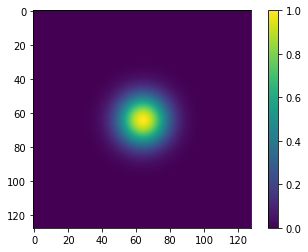

In [4]:
utils.view(Hfft[0,:])

A =
 [[6.30527392e-01 8.48833214e-02 5.98157092e-02 2.28212984e-01]
 [2.49457491e-02 1.95014984e-01 6.50146343e-02 3.30956999e-02]
 [8.84670114e-02 2.92155180e-02 2.14735128e-01 7.24435567e-01]
 [8.91958494e-02 6.94152928e-02 5.58711523e-01 7.61977134e-04]
 [1.24259312e-01 9.64838008e-01 3.04187432e-01 1.63776888e-01]
 [7.43466982e-01 1.00087558e-01 7.05298539e-02 2.69090322e-01]
 [6.99570975e-02 1.78052338e-02 1.67906235e-01 5.68139614e-01]
 [1.13811597e-01 8.85721182e-02 7.12901452e-01 9.72263114e-04]]


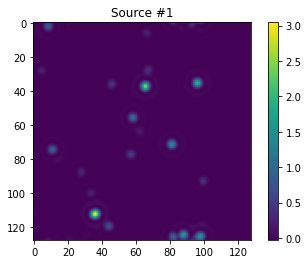

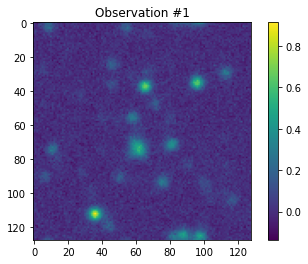

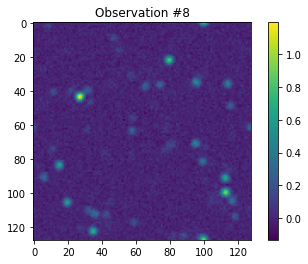

In [4]:
# View the data
print("A =\n", A0)
utils.view(S0[0,:], title='Source #1')
utils.view(Y[0,:], title='Observation #1')
utils.view(Y[-1,:], title='Observation #8')

# Joint deconvolution and blind source separation

In [5]:
# Initialize the parameters of DecGMCA
minWuIt = 50                        # minimum number of iterations at warm-up
c_wu = 0.5*np.array([1, 10])        # Tikhonov regularization hyperparameter at warm-up
c_ref = 0.5                         # Tikhonov regularization hyperparameter at refinement
cwuDec = 25                         # number of iterations for the decrease of c_wu
nStd = np.std(N)                    # noise standard deviation
useMad = False                      # use mad to estimate noise std in source space
nscales = 3                         # number of detail scales
k = 3                               # parameter of the k-std thresholding
K_max = 0.5                         # maximal L0 norm of the sources
L1 = True                           # L1 penalization
doRw = True                         # do l1 reweighing during refinement
eps = np.array([1e-2, 1e-6, 1e-4])  # stopping criteria

In [6]:
#Set the algorithm
decgmca = DecGMCA(Y, Hfft/Hfft[-1, :], n, minWuIt=minWuIt, c_wu=c_wu, c_ref=c_ref, cwuDec=cwuDec, nStd=nStd, 
                  useMad=useMad, nscales=nscales, k=k, K_max=K_max, L1=L1, doRw=doRw, eps=eps, verb=verb, S0=S0c, A0=A0)

In [7]:
# Run the algorithm
decgmca.run()
S = decgmca.S
A = decgmca.A

CA : 24.57 | NMSE: 22.95


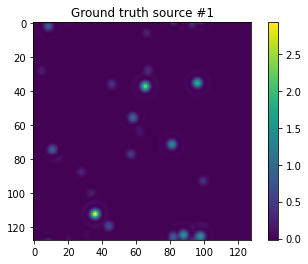

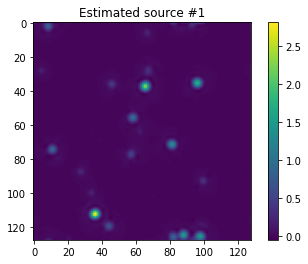

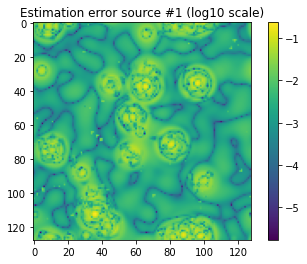

In [8]:
# Assess solution
utils.asses_solution(A0, S0c, A, S, corrPerm=True, viewData=False)
utils.view(S0c[0,:], title='Ground truth source #1')
utils.view(S[0,:], title='Estimated source #1')
utils.view(np.log10(np.abs(S0[0,:]-S[0,:])), title='Estimation error source #1 (log10 scale)')